In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from lmfit import Model, Parameters

from scripts.extensional_paras import (fit_velocity,
                                       recalculate_time)
from scripts.fitting import fit_poly

In [2]:
sns.set_style('darkgrid')
sns.set_context('paper', font_scale=0.7, rc={'grid.linewidth': 0.5})

In [3]:
print("numpy v{}".format(np.__version__))
import matplotlib
print("matplotlib v{}".format(matplotlib.__version__))
print("pandas v{}".format(pd.__version__))
print("seaborn v{}".format(sns.__version__))
import lmfit
print("lmfit v{}".format(lmfit.__version__))

numpy v1.26.2
matplotlib v3.8.1
pandas v2.1.3
seaborn v0.13.0
lmfit v1.2.2


Versions 20231124 (python 3.11):
```
numpy v1.25.2
matplotlib v3.7.1
pandas v2.0.3
seaborn v0.12.2
lmfit v1.2.2
```

In [4]:
sample_order = ['500cSt', '1000cSt']
palette = 'flare_r'

In [5]:
df_500cst_004 = pd.read_csv("..\\data\\20231124_si_oil_droplets\\20231124_500cSt_0.04ul_s.tsv", 
                            sep='\t', index_col=0)
df_1000cst_004 = pd.read_csv("..\\data\\20231124_si_oil_droplets\\20231121_1000cSt_0.04ul_s.tsv",
                             sep='\t', index_col=0)

In [6]:
df_hyper = pd.concat([df_500cst_004, df_1000cst_004])
filter_idx = (df_hyper['area_ratio'] < 1.04)
df_hyper = df_hyper.loc[filter_idx]

In [7]:
def fsize_cm(size_x, size_y):
    """
    
    :param size_x: Figure width in inch
    :param size_y: Figure height in inch
    :return: tuple(width, height) in cm
    """
    return size_x / 2.54, size_y / 2.54

##### Cut data into bins

In [8]:
x_feat = 'time_shift'
x_0 = -60
idx_hyper = (x_0 < df_hyper[x_feat]) \
            & (df_hyper[x_feat] < 550)

df_hyper = df_hyper[idx_hyper].copy()
# need to iterate over the flow rates to create bins then concatenate to big dataframe again
df_median = pd.DataFrame()
for sample in df_hyper['sample'].unique(): 
    df_fr = df_hyper.loc[df_hyper['sample'] == sample]
    if len(df_fr) > 0:
        bins = pd.cut(df_fr[x_feat], 300)
        df_grouped = df_fr.groupby(by=['sample', 'flow_rate', 'run_idx', bins],
                                   as_index=False
                                   )
        df_median = pd.concat([df_median, df_grouped.median(numeric_only=True)])
df_median.reset_index(inplace=True, drop=True)
# df_median = df_median[df_median['strain_inert'] > 0].copy()

C:\Users\freiche\AppData\Local\Temp\ipykernel_33168\2499512485.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_grouped = df_fr.groupby(by=['sample', 'flow_rate', 'run_idx', bins],
C:\Users\freiche\AppData\Local\Temp\ipykernel_33168\2499512485.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_grouped = df_fr.groupby(by=['sample', 'flow_rate', 'run_idx', bins],


In [9]:
df_median['dynamic_viscosity'] = df_median['sample'].map({'500cSt': 485, '1000cSt': 970})

In [47]:
print("Number of unique drops per condition:")
flow_rates = df_hyper['flow_rate'].unique()
samples = df_hyper['sample'].unique()
for sample in samples:
    for fr in flow_rates:
        df_samp_fr = df_hyper.loc[(df_hyper['sample'] == sample) 
                                  & (df_hyper['flow_rate'] == fr)]
        print(f"{sample} - {fr} ul/s: {len(df_samp_fr['object_number'].unique())}")

Number of unique drops per condition:
500cSt - 0.04 ul/s: 90
1000cSt - 0.04 ul/s: 421


### Analyze at constant extension rate

In [10]:
def strain_droplet_relaxation(t, tau, epsilon_0, epsilon_infty):
    """
    Return the strain based on a Kelvin-Voigt model with initial strain
    epsilon_0 at t=0.

    Parameters
    ----------
    t: time in seconds
    tau: Relaxation time in s
    epsilon_0: initial strain (without unit)
    epsilon_infty: steady state strain at t -> infinity 

    Returns
    -------
    Strain for the given parameters
    """
    return epsilon_0 * np.exp(-t / tau) + epsilon_infty * (1 - np.exp(-t / tau))

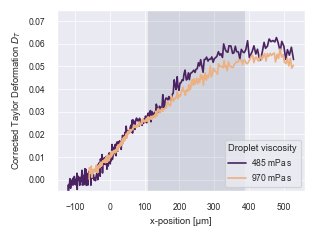

In [11]:
fsize = fsize_cm(8, 6)
fig, ax = plt.subplots(1, 1, figsize=fsize)

sns.lineplot(data=df_median,
             x='x_hyper', y='taylor_strain_ir_corr',
             hue='dynamic_viscosity',  palette=palette, #hue_order=sample_order,
             ax=ax
             )
y_min = -0.005
y_max = 0.075
ax.fill_between([110, 390], [y_max, y_max], [y_min, y_min], 
                lw=0, color='slategray', alpha=0.2, zorder=1)
ax.set_ylim(y_min, y_max)
ax.set_xlabel("x-position [µm]")
ax.set_ylabel("Corrected Taylor Deformation $D_T$")

handles, labels = ax.get_legend_handles_labels()
l_new = [f"{l} mPa$\,$s" for l in labels]
ax.legend(handles, l_new, title="Droplet viscosity", handletextpad=0.6, alignment='left',
          loc='lower right')
plt.tight_layout()
plt.show()

# save_path = "..\\figure_plots\\SI\\fig_s3_strain_corrected.pdf"
# fig.savefig(save_path, format='pdf', dpi=900,
#             bbox_inches='tight', pad_inches=fsize[0] / 50
#             )

In [13]:
fsize = fsize_cm(8, 6)
fig, ax = plt.subplots(1, 1, figsize=fsize)

sns.lineplot(data=df_median,
             x='x_hyper', y='taylor_strain_ir',
             hue='dynamic_viscosity',  palette=palette, #hue_order=sample_order,
             ax=ax
             )
ax.set_ylim(y_min, 0.075)
ax.set_xlabel("x-position [µm]")
ax.set_ylabel("Taylor Deformation- uncorrected $D_T$")

handles, labels = ax.get_legend_handles_labels()
l_new = [f"{l} mPa$\,$s" for l in labels]
ax.legend(handles, l_new, title="Droplet viscosity", handletextpad=0.6, alignment='left',
          loc='lower right')
plt.tight_layout()
plt.show()

# save_path = "..\\figure_plots\\SI\\fig_s3_strain_uncorrected.pdf"
# fig.savefig(save_path, format='pdf', dpi=900,
#             bbox_inches='tight', pad_inches=fsize[0] / 50
#             )

In [14]:
fsize = fsize_cm(8, 6)
fig, ax = plt.subplots(1, 1, figsize=fsize)

sns.lineplot(data=df_median,
             x='x_hyper', y='extension_rate_fit',
             hue='dynamic_viscosity',  palette=palette, #hue_order=sample_order,
             ax=ax
             )
ax.set_xlabel("x-position [µm]")
ax.set_ylabel("Extension rate [1/s]")

ax.set_ylim(0)

handles, labels = ax.get_legend_handles_labels()
l_new = [f"{l} mPa$\,$s" for l in labels]
ax.legend(handles, l_new, title="Droplet viscosity", handletextpad=0.6, alignment='left')
plt.tight_layout()
plt.show()

# save_path = "..\\figure_plots\\SI\\fig_s3_extension_rate.pdf"
# fig.savefig(save_path, format='pdf', dpi=900,
#             bbox_inches='tight', pad_inches=fsize[0] / 50
#             )

Cut data for zone of constant extension rate and small shear stress

In [15]:
x0_stable = 110
df_stable = df_median.loc[(x0_stable < df_median['x_hyper'])
                          & (df_median['x_hyper'] < 390)]

In [16]:
# Calculate time at stable extension rate
df_stable['x_stable'] = df_stable['x_hyper'] - x0_stable
df_analysis = pd.DataFrame()
for sample in df_stable['sample'].unique():
    idx_sample_fr = df_stable['sample'] == sample
    df_sample_fr = df_stable[idx_sample_fr]
    if len(df_sample_fr) > 0:
        velocity_poly = fit_velocity(df_sample_fr, x_feature='x_stable', degree=12)
        df_sample_fr = recalculate_time(df_sample_fr, velocity_poly,
                                        x_feature='x_stable',
                                        time_label='time_stable')
        df_analysis = pd.concat([df_analysis, df_sample_fr])

C:\Users\freiche\AppData\Local\Temp\ipykernel_33168\1118375739.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_stable['x_stable'] = df_stable['x_hyper'] - x0_stable
C:\Users\freiche\ownCloud\PhD\Projects\Extensional_flow_rheology\manuscript_hyperDC\Analysis\analysis_hyper_dc\scripts\extensional_paras.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[time_label] = np.array(times) * 1e-6
C:\Users\freiche\ownCloud\PhD\Projects\Extensional_flow_rheology\manuscript_hyperDC\Analysis\analysis_hyper_dc

In [17]:
fmodel = Model(strain_droplet_relaxation)
# define parameters that the fit models will use
params = Parameters()
params.add('tau', value=0.1, min=0, max=1)

df_fit = pd.DataFrame()
results_dict = {}
for sample in sample_order:
    for fr in df_analysis['flow_rate'].unique():
        df = df_analysis.loc[(df_analysis['sample'] == sample) 
                             & (df_analysis['flow_rate'] == fr)]
        if len(df) > 0:
            time = df['time_stable'].to_numpy()
            strain = df['taylor_strain_ir_corr'].to_numpy()
            # sort for time to get clean plot
            idx = np.argsort(time)
            time = time[idx]
            strain = strain[idx]
            # add initial strain to parameters
            s0 = strain[:5].min()
            s0_min = s0 - 0.2 * s0
            s0_max = s0 + 0.2 * s0
            params.add('epsilon_0', value=s0, min=s0_min, max=s0_max)
    
            s_infty = strain[-5:].max()
            s_infty_min = s_infty - 0.05 * s_infty
            s_infty_max = s_infty + 2 * s_infty
            params.add('epsilon_infty', value=s_infty, min=s_infty_min, max=s_infty_max)
            
            fit_result = fmodel.fit(strain, params, t=time, max_nfev=9000,
                                    nan_policy='omit')
            results_dict[sample] = fit_result
            df_fit_paras = pd.DataFrame()
            df_fit_paras['sample'] = [sample]
            df_fit_paras['flow_rate'] = [fr]
            for feat in ['tau', 'epsilon_0', 'epsilon_infty']:
                df_fit_paras[feat] = [fit_result.best_values[feat]]
                # std error of fit
                df_fit_paras[feat + '_err'] = fit_result.params[feat].stderr
                # relative error of fit
                df_fit_paras[feat + '_err_rel'] = (df_fit_paras[feat + '_err']
                                                   / df_fit_paras[feat])
            df_fit_paras['extension_rate'] = df['extension_rate_sample'].iloc[0]
            df_fit_paras['radius'] = df['diameter'].median() / 2
    
            df_fit = pd.concat([df_fit, df_fit_paras])

In [18]:
n_0 = 0.1
# n_d_theo = 0.97
df_fit['n_d_theo'] = df_fit['sample'].map({'500cSt': 0.485, '1000cSt': 0.97})

# viscosity ratio dense phase / dilute phase
df_fit['n_hat'] = np.sqrt(9/16 + 5/2 * df_fit['extension_rate'] * df_fit['tau'] / df_fit['epsilon_infty'])
df_fit['n_hat_err'] = np.sqrt((5 * df_fit['extension_rate']
                               / (np.sqrt(9 * df_fit['epsilon_infty']**2
                                          + 40 * df_fit['epsilon_infty']
                                          * df_fit['tau'] * df_fit['extension_rate']))
                               * df_fit['tau_err'])**2
                              + (5 * df_fit['extension_rate'] * df_fit['tau'] 
                                 / (np.sqrt(9 * df_fit['epsilon_infty']**4
                                            + 40 * df_fit['epsilon_infty']**3
                                            * df_fit['tau'] * df_fit['extension_rate']))
                                 * df_fit['epsilon_infty_err'])**2
                              )
n_hat_theo = df_fit['n_d_theo'] / n_0
# pre-factor dependent on viscosity ratio
df_fit['alpha'] = ((2 * df_fit['n_hat'] + 3) 
                   * (19 * df_fit['n_hat'] + 16) / (40 * (df_fit['n_hat'] + 1)))
alpha_theo = ((2 * n_hat_theo + 3)
              * (19 * n_hat_theo + 16) / (40 * (n_hat_theo + 1)))

df_fit['gamma [mN/m]'] = (5 / (2 * df_fit['n_hat'] + 3)  * df_fit['alpha'] * n_0 
                   * df_fit['extension_rate'] * df_fit['radius'] *1e-6
                   / df_fit['epsilon_infty'] 
                   *1e3
                   )
df_fit['gamma_err [mN/m]'] = np.sqrt((df_fit['gamma [mN/m]'] / df_fit['epsilon_infty'] 
                                      * df_fit['epsilon_infty_err'])**2
                                     + ((3/8 * n_0 * df_fit['extension_rate'] 
                                     * df_fit['radius'] *1e-6 
                                     / (df_fit['epsilon_infty'] * (df_fit['n_hat'] + 1)**2)
                                     * 1e3) * df_fit['n_hat_err'])**2
                                     )

df_fit['tau [ms]'] = df_fit['tau'] *1e3
df_fit['tau_err [ms]'] = df_fit['tau_err'] *1e3

df_fit['n_d [Pa.s]'] = n_0 * df_fit['n_hat']
df_fit['n_d_err [Pa.s]'] = n_0 * df_fit['n_hat_err']

In [19]:
df_fit

sample  flow_rate       tau   tau_err  tau_err_rel  epsilon_0  \
0   500cSt       0.04  0.017717  0.004230     0.238773   0.025149   
0  1000cSt       0.04  0.051617  0.024702     0.478569   0.025165   

   epsilon_0_err  epsilon_0_err_rel  epsilon_infty  epsilon_infty_err  ...  \
0       0.000680           0.027048       0.093336           0.011666  ...   
0       0.000374           0.014868       0.158868           0.058333  ...   

   n_d_theo     n_hat  n_hat_err     alpha  gamma [mN/m]  gamma_err [mN/m]  \
0     0.485  5.516122   0.729581  6.503806      1.030257          0.128804   
0     0.970  7.109737   2.120432  8.020002      0.635622          0.233411   

    tau [ms]  tau_err [ms]  n_d [Pa.s]  n_d_err [Pa.s]  
0  17.717105      4.230361    0.551612        0.072958  
0  51.616599     24.702110    0.710974        0.212043  

[2 rows x 23 columns]

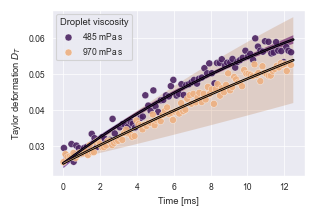

In [43]:
fsize = fsize_cm(8, 5.5)
fig, ax = plt.subplots(1, 1, figsize=fsize)

df_analysis['time [ms]'] = df_analysis['time_stable'] *1e3
sns.scatterplot(data=df_analysis,
                x='time [ms]', y='taylor_strain_ir_corr',
                hue='dynamic_viscosity',  palette='flare_r',
                s=25, lw=0.25, alpha=0.9, zorder=2, ax=ax)
ax.set_xlabel("Time [ms]")
ax.set_ylabel("Taylor deformation $D_T$")

handles, labels = ax.get_legend_handles_labels()
colors = [h.get_color() for h in handles]
alphas = [0.8, 0.2]
for ii, sample in enumerate(sample_order):
    fit_paras = df_fit.loc[df_fit['sample'] == sample]
    if len(fit_paras) > 0:
        t_plot = np.linspace(0, 0.0125, 100)
        tau_fr = fit_paras['tau'].iloc[0]
        e_0 = fit_paras['epsilon_0'].iloc[0]
        e_infty = fit_paras['epsilon_infty'].iloc[0]
        strain_plot = strain_droplet_relaxation(t_plot, tau_fr, e_0, e_infty)
        ax.plot(t_plot *1e3, strain_plot, 'k-', lw=1.8, zorder=4)
        # ax.plot(t_plot, strain_plot, 'w-', lw=1.2)
        ax.plot(t_plot *1e3, strain_plot, color=colors[ii], ls='-', lw=0.4, 
                zorder=5)
        
        fit_result = results_dict[sample]
        strain_eval = fit_result.eval(t=t_plot)
        err_band = fit_result.eval_uncertainty(t=t_plot, sigma=2)
        # desaturate the color for the error band
        band_color = sns.set_hls_values(color=colors[ii], l = 0.4)
        ax.fill_between(t_plot *1e3, strain_eval-err_band, strain_eval+err_band,
                        color=band_color, alpha=alphas[ii], edgecolor='none',
                        zorder=1,
                        # label="2-$\sigma$ uncertainty"
                        )

# ax.set_ylim(0, 0.07)
ax.tick_params(axis='both', which='major', pad=0)

l_new = [f"{l} mPa$\,$s" for l in labels]
ax.legend(handles, l_new, title="Droplet viscosity", handletextpad=0.6, alignment='left')

# add relaxation times to plot as text
# ax.text(6.5, 0.031, rf"$\tau(485\,$mPa$\,$s$) = {df_fit['tau [ms]'].iloc[0]:.1f}\,$ms", 
#         color=colors[0], fontsize=7)
# ax.text(6.5, 0.026, rf"$\tau(970\,$mPa$\,$s$) = {df_fit['tau [ms]'].iloc[1]:.1f}\,$ms", 
#         color=colors[1], fontsize=7)

plt.tight_layout()
plt.show()

save_path = "..\\figure_plots\\fig3.5_droplet_strain.pdf"
fig.savefig(save_path, format='pdf', dpi=900,
            bbox_inches='tight', pad_inches=fsize[0] / 50
            )

'1000cSt'

## Correction curves in inlet

In [ ]:
df_500cst_in = pd.read_csv("..\\data\\20231124_si_oil_droplets\\20231124_500cSt_inlet.tsv", 
                            sep='\t', index_col=0)
df_1000cst_in = pd.read_csv("..\\data\\20231124_si_oil_droplets\\20231121_1000cSt_inlet.tsv",
                             sep='\t', index_col=0)

In [ ]:
df_in = pd.concat([df_500cst_in, df_1000cst_in])
filter_idx = (df_in['area_ratio'] < 1.04)
df_in = df_in.loc[filter_idx]

In [ ]:
df_in['dynamic_viscosity'] = df_in['sample'].map({'500cSt': 485, '1000cSt': 970})

In [ ]:
def fit_inlet_data(df_in, strain_feat, fit_feat, x_feat='pos_x'):
    strain_polys = {}
    df_in[fit_feat] = np.nan

    for sample in df_in['sample'].unique():
        idx = df_in['sample'] == sample
        df_sample = df_in.loc[idx]
        x = df_sample[x_feat].to_numpy()
        y = df_sample[strain_feat].to_numpy()

        # remove nans
        non_nan = ~(np.isnan(x) | np.isnan(y))
        x_nonan = x[non_nan]
        y_nonan = y[non_nan]
        poly_strain_corr = fit_poly(x_nonan, y_nonan, 6)
        strain_polys[f'{sample}'] = poly_strain_corr

        df_in[fit_feat][idx] = poly_strain_corr(df_sample['pos_x'])

    return strain_polys, df_in

Fit polynomial to inlet data

In [ ]:
strain_feat = 'taylor_strain_ir'
fit_feat = 'strain_fit_taylor_ir'
x_feat = 'x_inlet'

taylor_polys, df_in_median = fit_inlet_data(df_in, strain_feat, fit_feat)

In [ ]:
fsize = fsize_cm(8, 6)
fig, ax = plt.subplots(1, 1, figsize=fsize)

sns.lineplot(data=df_in_median, x=x_feat, y=strain_feat,
             hue='dynamic_viscosity', palette=palette,
             ax=ax)
ax.set_xlabel("x-position ROI [µm]")
ax.set_ylabel("Taylor deformation $D_T$")
# ax.set_ylim(0)
ax.legend(loc='lower left', fontsize=12)

samples = df_in_median['sample'].unique()
for ii, sample in enumerate(samples):
    idx = df_in_median['sample'] == sample
    df = df_in_median[idx].copy()

    x = df[x_feat].to_numpy()
    y = df[fit_feat].to_numpy()
    ii_sort = np.argsort(x)
    x = x[ii_sort]
    y = y[ii_sort]
    ax.plot(x, y, c='k', ls='-.', lw=1)

l_new = [f"{l} mPa$\,$s" for l in labels]
ax.legend(handles, l_new, title="Droplet viscosity", handletextpad=0.6, alignment='left',
          loc='upper center')

plt.tight_layout()
plt.show()

# save_path = "..\\figure_plots\\SI\\fig_s3_corrected_curve.pdf"
# fig.savefig(save_path, format='pdf', dpi=900,
#             bbox_inches='tight', pad_inches=fsize[0] / 50
#             )

In [ ]:
taylor_polys